In [1]:
import yaml
import sys
import os
import numpy as np
import torch 
os.chdir('/home/jonfrey/PLR3')
sys.path.insert(0, os.getcwd())
sys.path.append(os.path.join(os.getcwd() + '/src'))
sys.path.append(os.path.join(os.getcwd() + '/lib'))

import loaders_v2
from loaders_v2 import GenericDataset
from rotations import * 

exp_cfg_path = '/home/jonfrey/PLR3/yaml/exp/exp_ws_deepim_debug_natrix.yml'
env_cfg_path = '/home/jonfrey/PLR3/yaml/env/env_natrix_jonas.yml'

def load_from_file(p):
    if os.path.isfile(p):
        with open(p, 'r') as f:
            data = yaml.safe_load(f)
    else:
        raise ValueError
    return data

exp = load_from_file(exp_cfg_path)
env = load_from_file(env_cfg_path)

dataset_train = GenericDataset(
    cfg_d=exp['d_train'],
    cfg_env=env)

batch = dataset_train[100][0] #bann 10450
points, choose, img, target, model_points, idx = batch[0:6]
depth_img, label_img, img_orig, cam = batch[6:10]
gt_rot_wxyz, gt_trans, unique_desig = batch[10:13]

real_img, render_img, real_d, render_d, gt_label_cropped = batch[13:18]
pred_rot_wxyz, pred_trans, pred_points, h_render_in, render_img_original = batch[18:23]
u_map, v_map, valid_flow_mask_cropped = batch[23:]


import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

class Drawer():
    def __init__(self):
        self.im_in_plot = 0
        self.data = []
    def disp_img_1d(self,img,hold=False):
        self.data.append(img)
        
        if not hold:
            fig = plt.figure(figsize=(6*2*len(self.data),7))
            ax = []
            for j,a in enumerate(self.data):
                ax.append( fig.add_subplot(1,len(self.data), j+1)  )
                
                ax[-1].get_xaxis().set_visible(False)
                ax[-1].get_yaxis().set_visible(False)
                pos = ax[-1].imshow( a, cmap='Blues' )
                fig.colorbar(pos, ax=ax[-1])
            plt.show()
            self.data = []
            self.ax = []



h = 480
w = 640

from visu import plot_pcd, Visualizer
import copy
from scipy.spatial.transform import Rotation as R
from helper import re_quat
from PIL import Image, ImageDraw

def transform_mesh(data, H):
        """ directly operates on mesh and does not create a copy!"""
        t = np.ones((data.shape[0],4)) 
        t[:,:3] = data
        data = (t @ H.T)[:,:3]
        return data
    
visu= Drawer()
visualizer = Visualizer(p_visu='home/jonfrey/Debug')   

Start loading meshes
Finished loading meshes 1.688692569732666
Finished with 500 matches and within 1114 iteartions, len(out), 34151 within: 0.3596477508544922s
Grid data time 0.19052743911743164


/home/jonfrey/PLR3/src/helper/bounding_box.py:269: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  masked_idx = (d != 0).nonzero()


shift disparity time: 25.28377938270569s
<class 'torch.Tensor'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shift disparity time: 0.010099172592163086s
186683.0
186489.0
get_rendered_data time 28.540900468826294s
Getitem time: 28.576377630233765


In [2]:
batch = dataset_train[20450][0] #bann 10450
points, choose, img, target, model_points, idx = batch[0:6]
depth_img, label_img, img_orig, cam = batch[6:10]
gt_rot_wxyz, gt_trans, unique_desig = batch[10:13]

real_img, render_img, real_d, render_d, gt_label_cropped = batch[13:18]
pred_rot_wxyz, pred_trans, pred_points, h_render_in, render_img_original = batch[18:23]
u_map, v_map, valid_flow_mask_cropped = batch[23:]

Finished with 500 matches and within 965 iteartions, len(out), 41829 within: 0.4055933952331543s
Grid data time 0.1690502166748047
shift disparity time: 25.268502235412598s
<class 'torch.Tensor'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shift disparity time: 0.015582799911499023s
167152.0
159393.0
get_rendered_data time 28.363340377807617s
Getitem time: 28.42009401321411


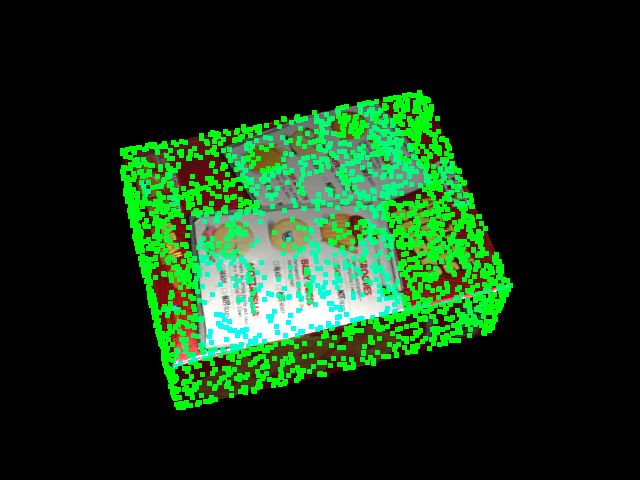

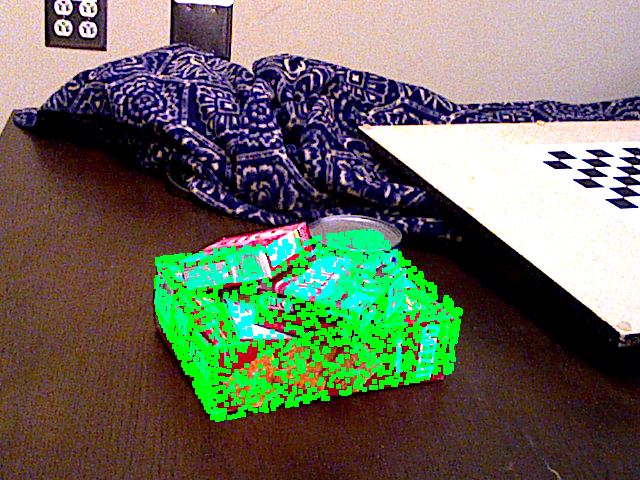

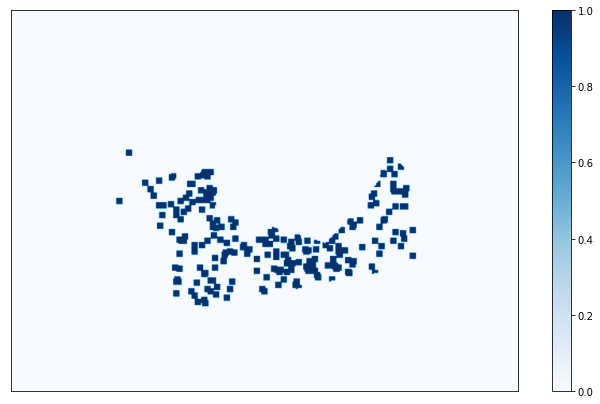

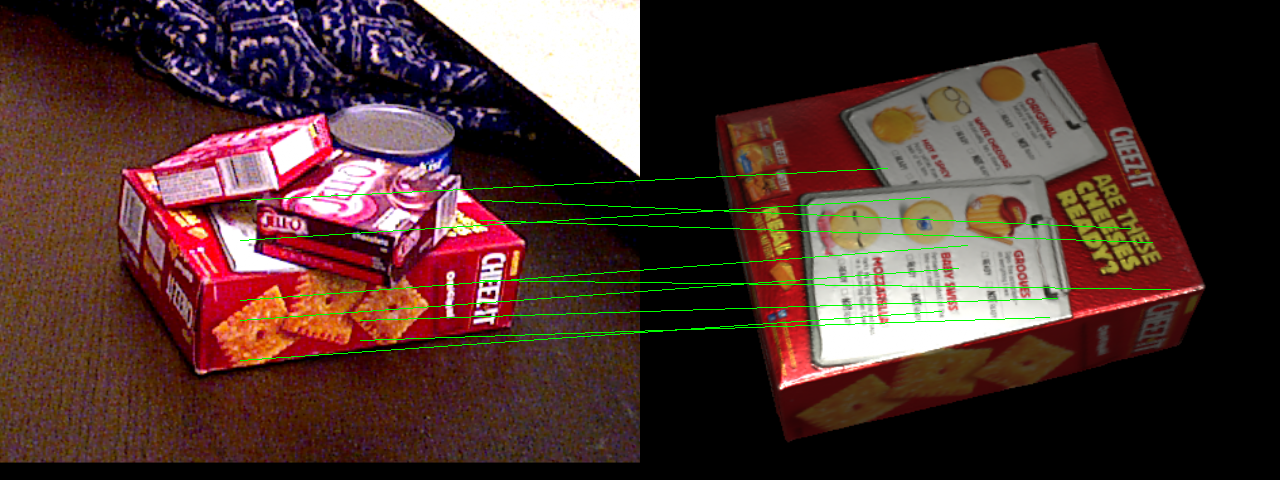

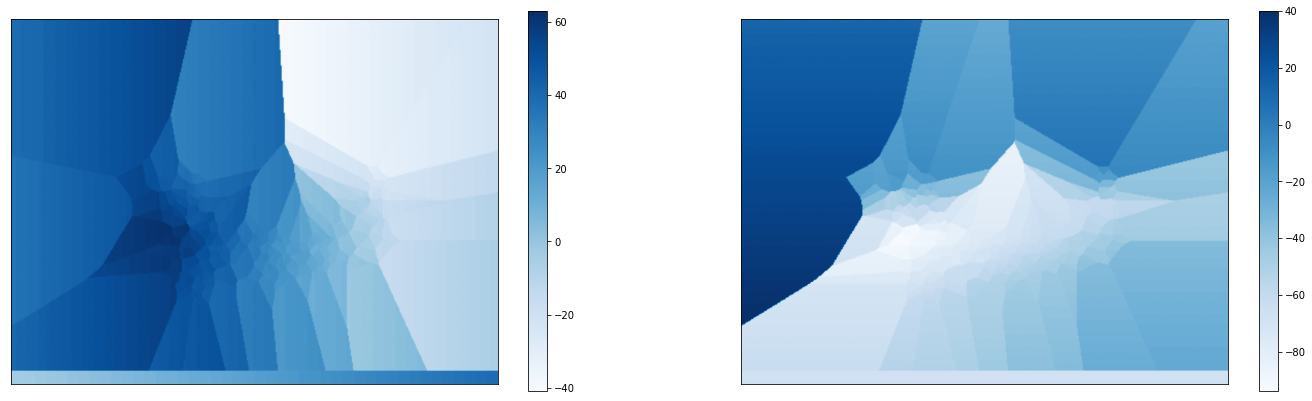

In [5]:
import cv2

data = dataset_train._backend.mesh[2].vertices[::100,:]
h_render = h_render_in.numpy()[0]
# X-coordinate points downward in image 
# Y-coordingate points right in image

# plot_pcd( data )

data = transform_mesh(copy.deepcopy( data ), h_render)
K1 = dataset_train._backend.get_camera('data_syn/000001', K=True) #data/0068/000001

# img1 = np.uint8( render_img.permute(1,2,0).numpy()) #for cropped

img1 = np.uint8(render_img_original.numpy()[0])
visualizer.plot_estimated_pose(tag='',epoch=0,img =img1,points=data, K=K1 ,jupyter=True)

img2 = np.uint8(img_orig.numpy())
rot = R.from_quat(re_quat( copy.copy(gt_rot_wxyz) , 'wxyz') ).as_matrix()
h_real = np.eye(4)
h_real[:3,:3] = rot
h_real[:3,3] = gt_trans
data2 = dataset_train._backend.mesh[2].vertices[::100,:]
data2 = transform_mesh(copy.deepcopy( data2 ), h_real)
visualizer.plot_estimated_pose(tag='',epoch=0,img =img2,points=data2, K=K1 ,jupyter=True)

# display( Image.fromarray( img1 ) )
# display( Image.fromarray( img2 ) )
# cor = np.zeros((h,w,1)) 
# img3 =  copy.deepcopy( img1)
# for j, ray in enumerate( render_res[1] ):
#     w_,h_ = dataset_train._backend.nr_to_image_plane[ray]
#     cor[int(h_),int(w_),:] = render_res[2][j]
# cor2 = np.zeros((h,w,1)) 
# img4 =  copy.deepcopy( img2)
# for j, ray in enumerate( real_res[1] ):
#     w_,h_ = dataset_train._backend.nr_to_image_plane[ray]
#     cor2[int(h_),int(w_),:] = real_res[2][j]
      
# display( Image.fromarray( np.uint8(cor) ) )
# display( Image.fromarray( np.uint8(cor2) ) )         


# comp_img = np.concatenate( [img2, img1], axis=1)
# rep = np.repeat( cor[:,:,:],3,2) 
# rep2 = np.repeat( cor2[:,:,:],3,2) 
# map_img = Image.fromarray(np.uint8(rep))
# map_img2 = Image.fromarray(np.uint8(rep2))
# comp_img = np.concatenate( [img2, map_img], axis=1)


# comp_img = Image.fromarray(comp_img)
# draw3 = ImageDraw.Draw(comp_img)

visu.disp_img_1d( valid_flow_mask_cropped )



cropped_comp = np.swapaxes( np.concatenate( [real_img.numpy(), render_img.numpy() ], axis=2).astype(np.uint8).T,0,1)
cropped_comp_img = Image.fromarray(cropped_comp)
draw = ImageDraw.Draw(cropped_comp_img)


col = (0,255,0)
for _w in range(0,w,120):
    for _h in range(0,h,20):       
        if valid_flow_mask_cropped[_h,_w] != 0:
            try:
                delta_h = v_map[_h,_w]
                delta_w = u_map[_h,_w]
                draw.line([(int(_w), int(_h)), (int(_w +640 - delta_w ), int( _h - delta_h))],
                  fill=col, width=1)
            except:
                print('failed')
display( cropped_comp_img )

#             uuu = u_full[_h,_w]
#             vvv = v_full[_h,_w]

#             draw3.line([(_w, _h), (int(_w +640+vvv ), _h + uuu)],
#               fill=col, width=1)
            
# #             except:
# #                 pass 
# display( comp_img )
dra= Drawer()
dra.disp_img_1d(v_map, True)
dra.disp_img_1d(u_map)
# dra= Drawer()
# dra.disp_img_1d( cor2[:,:,0],True )
# dra.disp_img_1d( cor[:,:,0] )
  
        

In [15]:
grid_x, grid_y = np.mgrid[0:h, 0:w]
g = np.stack([grid_x,grid_y], axis=2)
data = np.ones((h,w))
nr1 = 1
nr2 = 2
nr3 = 3
nr4 = 4
import time
st = time.time()
arr = np.round(g[:,:,1]-(np.round((((g[:,:,1]/(nr1)+nr2) +np.round(data[:,:]))-nr3)*(nr4))))
print(time.time()-st)

0.00632476806640625
